In [1]:
import sys
sys.path.append('../')

import numpy as np
import networkx as nx
import itertools
import torch
import torch.nn.functional as F
import torch_sparse
import random 

from torch import nn
from models.difussion_models import GraphLaplacianDiffusion, OneDimSheafDiffusion, MultiDimSheafDiffusion
from lib.laplace import build_norm_sheaf_laplacian, remove_duplicate_edges, build_sheaf_difussion_matrix, dirichlet_energy
from torch_geometric.nn.dense.linear import Linear
from scipy import linalg
from torch_geometric.utils import to_dense_adj, from_networkx
from torch_geometric.nn.conv import GCNConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

#### Create bipartite dataset

In [2]:
def create_graph_dataset(num_nodes=99, max_edges_per_V_node=6, input_features=5, inter_p=1.0, classes=3, num_edges=1000):
    assert 0 <= inter_p <= 1.0
    # We randomly generate graphs until we produce a connected one
    graph = nx.Graph()

    # Partition the graph into two sets. 
    nodes = np.arange(0, num_nodes).reshape(classes, -1)
    graph.add_nodes_from(nodes.flatten())

    # Randomly generate edges between nodes
    edges = []
    for _ in range(num_edges):
        current_class = random.randint(0, classes-1)
        nodes_from_other_classes = np.concatenate((nodes[:current_class, :],nodes[current_class+1:, :]))
        v_node = random.choice(nodes[current_class])

        sample = np.random.uniform(0, 1)
        if sample <= inter_p:
            u_node = random.choice(nodes_from_other_classes.flatten())
        else:
            u_node = random.choice(nodes[current_class])
        if u_node != v_node:
            edges.append((v_node, u_node))
    graph.add_edges_from(edges)
        
    # Convert the graph to a PyTorch geometric data object
    data = from_networkx(graph)

    # Add dummy features to the graph
    x_V = torch.empty(num_nodes // classes, input_features).normal_(mean=-0.3,std=0.5)
    x_U = torch.empty(num_nodes // classes, input_features).normal_(mean=0.0,std=0.5)
    x_W = torch.empty(num_nodes // classes, input_features).normal_(mean=0.3,std=0.5)

    x = torch.cat((x_V, x_U, x_W), dim=0)
    data.x = x

    # Add labels
    y = torch.arange(classes).view(-1, 1).tile(1,33).view(-1, )
    data.y = y
    
    # Meta
    data.num_nodes = num_nodes
    data.in_features = input_features
    
    return data, graph

In [3]:
inter_p=1.0
train, graph = create_graph_dataset(inter_p=inter_p)
test, _ = create_graph_dataset(inter_p=inter_p)
test.edge_index = train.edge_index

True
torch.Size([99, 5])
torch.Size([99])
871


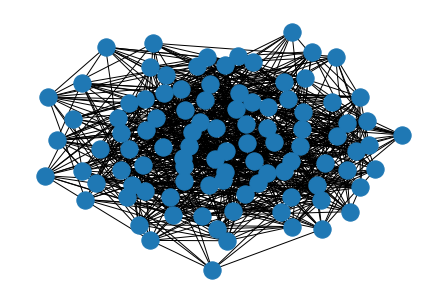

In [4]:
nx.draw(graph)
print(nx.is_connected(graph))
print(train.x.size())
print(train.y.size())
print(len(graph.edges()))

#### Train One Laplacian difussion models

In [16]:
times = torch.arange(0, 10, step=1.0)
times[0] = 0.00001

In [17]:
def eval_model(model, data):
    model.eval()
    pred = model(data.x).argmax(dim=1)
    correct = (pred == data.y).sum()
    acc = int(correct) / int(data.num_nodes)
    return acc

In [18]:
diff_train_acc, diff_test_acc = [], []
for t in times:
    model = OneDimSheafDiffusion(train.num_nodes, train.edge_index, torch.tensor([0.0, t]), train.in_features, hidden_dim=10, output_dim=3, normalized=False) 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(201):
        optimizer.zero_grad()
        out = model(train.x)
        loss = F.nll_loss(out, train.y)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0 and epoch > 0:
            print(f"Epoch: {epoch} | Loss: {loss.item()}")
            
    train_acc = eval_model(model, train)
    test_acc = eval_model(model, test)
    print('Train Accuracy: {:.4f}'.format(train_acc))
    print('Test Accuracy: {:.4f}'.format(test_acc))
    
    diff_train_acc.append(train_acc)
    diff_test_acc.append(test_acc)

Epoch: 100 | Loss: 0.541903200490336
Epoch: 200 | Loss: 0.5418879330413209
Train Accuracy: 0.7374
Test Accuracy: 0.6768
Epoch: 100 | Loss: 0.3828501511943552
Epoch: 200 | Loss: 0.28425041500783854
Train Accuracy: 0.8990
Test Accuracy: 0.7475
Epoch: 100 | Loss: 0.3935278473824863
Epoch: 200 | Loss: 0.272756817289939
Train Accuracy: 0.9192
Test Accuracy: 0.7475
Epoch: 100 | Loss: 0.3905875590784791
Epoch: 200 | Loss: 0.2665042423531131
Train Accuracy: 0.8990
Test Accuracy: 0.7879
Epoch: 100 | Loss: 0.4090005486264565
Epoch: 200 | Loss: 0.29067304165861396
Train Accuracy: 0.9091
Test Accuracy: 0.7374
Epoch: 100 | Loss: 0.392865139840065
Epoch: 200 | Loss: 0.291192784078999
Train Accuracy: 0.9091
Test Accuracy: 0.7879
Epoch: 100 | Loss: 0.42650708910221335
Epoch: 200 | Loss: 0.3188642965568873
Train Accuracy: 0.8687
Test Accuracy: 0.7475
Epoch: 100 | Loss: 0.39264399572994146
Epoch: 200 | Loss: 0.2760401273132481
Train Accuracy: 0.8990
Test Accuracy: 0.7778
Epoch: 100 | Loss: 0.38297601575

#### Train Sheaf Difussion Model

In [19]:
sheaf_train_acc, sheaf_test_acc = [], []
for t in times:
    model = MultiDimSheafDiffusion(train.num_nodes, train.edge_index, 2, torch.tensor([0.0, t]), train.in_features, hidden_dim=10, output_dim=3, normalised=False)   
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(201):
        optimizer.zero_grad()
        out = model(train.x)
        loss = F.nll_loss(out, train.y)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0 and epoch > 0:
            print(f"Epoch: {epoch} | Loss: {loss.item()}")
            
    train_acc = eval_model(model, train)
    test_acc = eval_model(model, test)
    print('Train Accuracy: {:.4f}'.format(train_acc))
    print('Test Accuracy: {:.4f}'.format(test_acc))
    
    sheaf_train_acc.append(train_acc)
    sheaf_test_acc.append(test_acc)

Epoch: 100 | Loss: 0.541861859021047
Epoch: 200 | Loss: 0.5418902718961321
Train Accuracy: 0.7374
Test Accuracy: 0.6768
Epoch: 100 | Loss: 0.1136896089866051
Epoch: 200 | Loss: 0.030213709056658808
Train Accuracy: 1.0000
Test Accuracy: 0.7778
Epoch: 100 | Loss: 0.1372297421636801
Epoch: 200 | Loss: 0.04686255793897063
Train Accuracy: 1.0000
Test Accuracy: 0.7879
Epoch: 100 | Loss: 0.09250439040217404
Epoch: 200 | Loss: 0.032782945164825446
Train Accuracy: 1.0000
Test Accuracy: 0.7778
Epoch: 100 | Loss: 0.1605880924599587
Epoch: 200 | Loss: 0.04318397123759722
Train Accuracy: 1.0000
Test Accuracy: 0.7475
Epoch: 100 | Loss: 0.2775533528902876
Epoch: 200 | Loss: 0.1461731032321877
Train Accuracy: 0.9495
Test Accuracy: 0.7071
Epoch: 100 | Loss: 0.283002569037265
Epoch: 200 | Loss: 0.12463170602662665
Train Accuracy: 0.9899
Test Accuracy: 0.7677


KeyboardInterrupt: 

#### Plotting

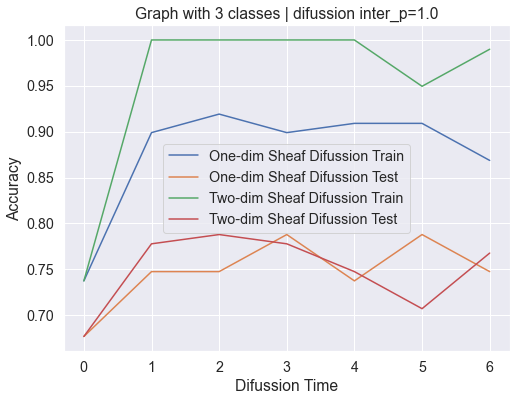

In [20]:
# Performance as a function of the difussion time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3)  

plt.figure(figsize=(8, 6))
maxt = 7
plt.plot(times[:maxt], diff_train_acc[:maxt], label='One-dim Sheaf Difussion Train')
plt.plot(times[:maxt], diff_test_acc[:maxt], label='One-dim Sheaf Difussion Test')
plt.plot(times[:maxt], sheaf_train_acc[:maxt], label='Two-dim Sheaf Difussion Train')
plt.plot(times[:maxt], sheaf_test_acc[:maxt], label='Two-dim Sheaf Difussion Test')
plt.legend()
plt.title(fr"Graph with 3 classes | difussion inter_p={inter_p}")
plt.xlabel('Difussion Time')
plt.ylabel('Accuracy')
plt.show()

#### Examining the learned Laplacian

In [11]:
# Define the model
model = OneDimSheafDiffusion(train.num_nodes, train.edge_index, torch.tensor([0.0, times[-1]]), train.in_features, hidden_dim=10, output_dim=3)   
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Check how the entries of the Laplacian look like in the beginning
maps = model.sheaf_learner(model.lin1(train.x), train.edge_index)
L_index, L_val = model.laplacian_builder(maps)
non_diag_vals_before = L_val[L_index[0] != L_index[1]]

# Check the weights of the Laplacian before
weights_before = model.sheaf_learner.map_builder.weight.data.detach().numpy().flatten()

model.train()
for epoch in range(201):
    optimizer.zero_grad()
    out = model(train.x)
    loss = F.nll_loss(out, train.y)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0 and epoch > 0:
        print(f"Epoch: {epoch} | Loss: {loss.item()}")

train_acc = eval_model(model, train)
test_acc = eval_model(model, test)
print('Train Accuracy: {:.4f}'.format(train_acc))
print('Test Accuracy: {:.4f}'.format(test_acc))

# Check how the entries of the Laplacian look like in the beginning
maps = model.sheaf_learner(model.lin1(train.x), train.edge_index)
L_index, L_val = model.laplacian_builder(maps)
non_diag_vals_after = L_val[L_index[0] != L_index[1]]

# Check the weights of the Laplacian after 
weights_after = model.sheaf_learner.map_builder.weight.data.detach().numpy().flatten()

Epoch: 100 | Loss: 0.14038072362627443
Epoch: 200 | Loss: 0.06828790286476151
Train Accuracy: 1.0000
Test Accuracy: 1.0000


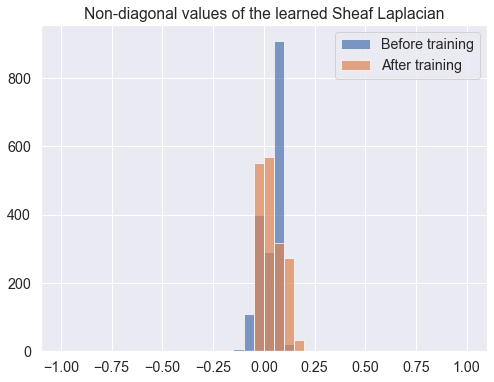

In [12]:
# The structure of the learned Laplacian 
plt.figure(figsize=(8, 6))
plt.hist(non_diag_vals_before.detach().numpy(), bins=40, range=(-1, 1), alpha=0.7, label='Before training')
plt.hist(non_diag_vals_after.detach().numpy(), bins=40, range=(-1, 1), alpha=0.7, label='After training')
plt.legend()
plt.title(fr"Non-diagonal values of the learned Sheaf Laplacian")
plt.show()

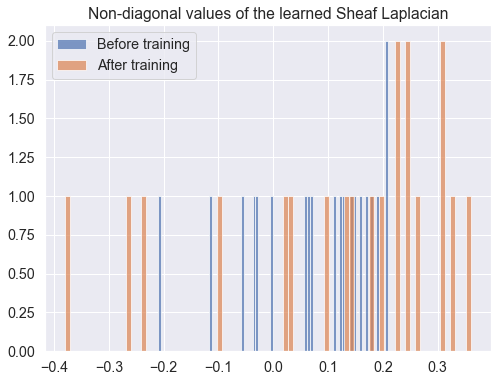

In [38]:
# The value of the weights learning the Laplacian 
plt.figure(figsize=(8, 6))
plt.hist(weights_before, bins=80, alpha=0.7, label='Before training')
plt.hist(weights_after, bins=80, alpha=0.7, label='After training')
plt.legend()
plt.title(fr"Non-diagonal values of the learned Sheaf Laplacian")
plt.show()